## A/B Testing primer

Within the theory of A/B testing, we generally wish to compare the conversion rates of group $B$ with control group $A$. We start by assuming two random processes describing the number of conversions, $A$ and $B$, with probabilities of conversion denoted by $p_A$ and  $p_B$ respectively. We assume each process follows a binomial distribution and each experiment is performed $n$ times.

$$
A \sim \text{Bin}(n, p_A) \\
B \sim \text{Bin}(n, p_B)
$$

When performing an A/B test, the goal is to determine whether the difference in conversion rates is significant. We can use the [CLT](https://en.wikipedia.org/wiki/Central_limit_theorem) to approximate the difference between the two distributions as a normal distribution.

$$
B - A \sim \text{N}(n p_B - n p_A, n p_B q_B + n p_A q_A) \\
$$

For a given sample from $B$, $b$, and a given sample from $A$, $a$, we can compute a [Z-score](https://en.wikipedia.org/wiki/Standard_score) to determine whether the difference in conversion rates is meaningful.

$$
z=\frac{b-a}{\sqrt{n p_A (1 - p_A) + n p_B (1 - p_B)}} \\
$$

In practice, $p_A$ and $p_B$ are not observable and so we use the sample probabilities as our best approximations to these values.

## Extending Tests

We are interested in the case where the two distributions are equal and, therefore, the null hypothesis is in fact true (i.e. $p_A = p_B$). We can consider the distribution of Z-scores we might expect if we calculate our Z-score many times. Clearly Z will be a random variable:

$$
Z=\frac{B-A}{\sqrt{n p_A (1 - p_A) + n p_B (1 - p_B)}}
$$

Checking moments:

$$
\mathbb{E}[Z] = \frac{\mathbb{E}[B] - \mathbb{E}[A]}{\sqrt{n p_A (1 - p_A) + n p_B (1 - p_B)}} = 0 \\
\text{var}[Z] = \frac{\text{var}[A] + \text{var}[B]}{n p_A (1 - p_A) + n p_B (1 - p_B)} = 1
$$

So $Z \sim N(0,1)$ exactly as expected. That's good. This means we can avoid simulating $2 \times n$ tests for each distribution and simulate a single random normal instead. That should be much more efficient.

## Simulating a running Z-score through time

Let's suppose we run the experiment across two days. On day 1, we have $A_1, B_1, Z_1$ and on day 2, we have $A_2, B_2, Z_2$. We can also define $\hat{Z}_2$ as the running, two-day total Z-score. In order to simulate a running total Z-score, we need to link $\hat{Z}_2$ to our daily Z-scores, $Z_1$ and $Z_2$.

If we calculate $\hat{Z}_2$ from first principles, we know that $\hat{Z}_2 \propto (B_1 + B_2)-(A_1 + A_2)$ and will be distributed $\hat{Z}_2 \sim N(0,1)$. Substituting in for $Z_1$ and $Z_2$, we get

$$
\hat{Z}_2 \propto Z_1 + Z_2
$$

Or simply $\hat{Z}_2 = k (Z_1 + Z_2)$ for some constant $k$. We have to satisfy the requirement that $\hat{Z}_2$ has unit variance, and so we can easily solve for $k$ as follows.

$$
\text{var}[\hat{Z}_2] = 1 = k^2 \text{var}[Z_1 + Z_2]= 2 k^2
$$

which implies

$$
\hat{Z}_2 = \frac{ Z_1 + Z_2}{\sqrt{2}}
$$

Generalising to $t$ days in the obvious way, we can write

$$
\hat{Z}_t = \frac{ \sum_{i=1}^{t} Z_i}{\sqrt{t}}
$$

This gives us everything we need to simulate the evolution of Z-score through time. Over $t$ days, we can simulate $t$ random normal variables. The running Z-score is simply the sum of all the Z-scores up to that point, divided by the square root of time.

## The problem with extending tests

We have all the tools we need to demonstrate the problem with extending tests to reach significance. Let's consider the scenario in which a test has run for 10 days and almost reached significance but just fell short. The experimenter decides to run the test for a further 5 days to see if significance can be reached. We'll denote the significance observed after 10 days by $\hat{z}^*_{10}$ and the required significance as $z_{req}$ (and clearly we found that $\hat{z}^*_{10} < z_{req}$).

Writing out the equation for our 15 day running Z-score in full:

$$
\hat{Z}_{15} = \frac{Z_1 + ... + Z_{10} + Z_{11} + ... + Z_{15}}{\sqrt{15}}
$$

Next, we substitute in for $Z_1 + ... + Z_{10} = \sqrt{10} \hat{z}^*_{10}$ and $Z_{11} + ... + Z_{15} = \sqrt{5} Z$ to obtain

$$
\hat{Z}_{15} = \frac{\sqrt{10} \hat{z}^*_{10} + \sqrt{5}Z}{\sqrt{15}}
$$

So our extended Z-score distribution has moved from $N(\mu=0,\sigma=1)$ to $N(\mu=\sqrt{\frac{10}{15}}\hat{z}^*_{10},\sigma=\sqrt{\frac{5}{15}})$. This is the crux of the problem with extending tests - our Z-scores are no longer standard normals.

Generalising, for an experiment that ran to time $t$, achieving a Z-score of $\hat{z}^*_{t}$, and is subsequently extended to time $T$ (where $t<T$), we find that

$$
\hat{Z}_{t,T} \sim N(\mu=\sqrt{\frac{t}{T}}\hat{z}^*_{t},\sigma=\sqrt{1-\frac{t}{T}})
$$

This equation certainly passes our reasonable checks; as $T \to\infty$, we obtain $\hat{Z}_{t,\infty} \sim N(\mu=0,\sigma=1)$ which confirms that we can recover the long-term Z distribution. Likewise, when $t=T$, we recover the observed Z-score at time $t$ precisely.

Let's plot the distribution through time to see how the Z-scores evolve. We shall assume that $z_{req}$ corresponds to a 95% confidence and ${z}^*_{10}$ only reached 90% confidence. We'll chart the 5, 25, 50, 75, 95th percentiles to help visualise the distribution.

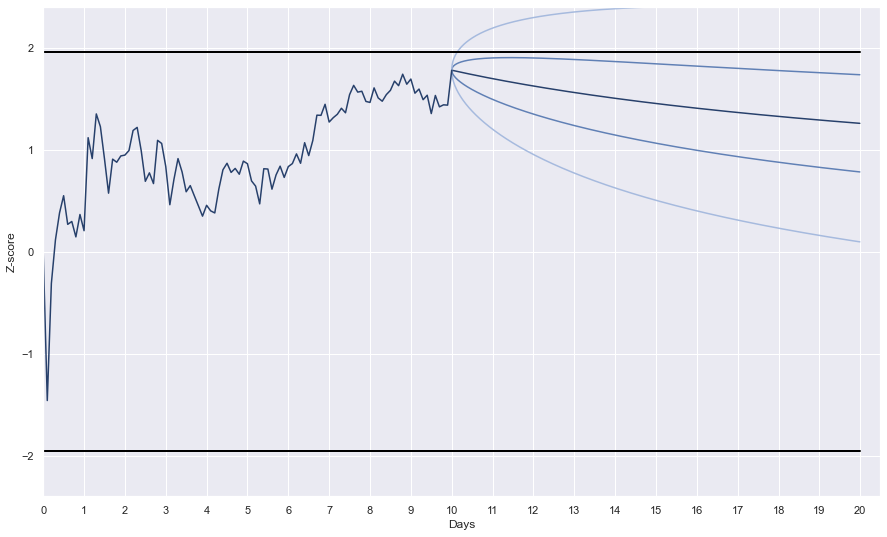

In [9]:
from typing import List
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


t = 10
t_extended = 20
confidence_required = 0.95
confidence_achieved = 0.925
is_two_sided_test = True


def simulate_z_scores(days: int, simulations:int = 1_000_000) -> np.ndarray:

    np.random.seed(770)
    daily_z_scores = np.random.normal(size=(simulations, days+1))
    daily_z_scores[:, 0] = 0
    rolling_scores = np.cumsum(daily_z_scores, axis=1)
    day_range = np.arange(0, days+1)
    scalars = np.divide(1, day_range, where=day_range!=0)
    scalars[0] = 0
    scalars = scalars ** 0.5

    return rolling_scores * scalars

def get_z_score(probability: float, is_two_sided_test: bool) -> float:
    if is_two_sided_test:
        upper_probability = 1-(1-probability)/2
        return norm.ppf(upper_probability)
    
    return norm.ppf(probability)
        
def simulate_historical_path(t: int, z: float):
    z_scores = simulate_z_scores(t, 1000)
    maxes = np.max(z_scores, axis=1)
    mins = np.min(z_scores, axis=1)
    z_scores = z_scores[(maxes<z) & (mins>-z),:]
    idx = np.abs(np.abs(z_scores[:, -1]) - np.abs(z)).argmin()
    z_row = z_scores[idx, :]
    scalar = z / z_row[-1]
    return z_row * scalar

def calculate_z_score_percentiles(t: float, z_achieved: float, extended_times: List[float], percentiles: List[float]) -> pd.DataFrame:
    expected_z = np.sqrt(t / extended_times) * z_achieved
    sigmas = np.sqrt(1 - t / extended_times)
    z_percentiles = norm.ppf(percentiles)
    matrix = expected_z[:, np.newaxis] + z_percentiles * sigmas[:, np.newaxis]
    return pd.DataFrame(data=matrix, columns=percentiles, index=extended_times)

z_required = get_z_score(confidence_required, is_two_sided_test)
z_achieved = get_z_score(confidence_achieved, is_two_sided_test)

extended_times = np.arange(t, t_extended, 0.01)
percentiles = np.array([0.05, 0.25, 0.50, 0.75, 0.95])

df = calculate_z_score_percentiles(t, z_achieved, extended_times, percentiles)
ax = df.plot(legend=False, figsize=(15,9))
ax.set_xticks(np.arange(0, t_extended+1, 1))
ax.set_ylim([-2.4, 2.4])
ax.set_xlabel('Days')
ax.set_ylabel('Z-score')

# Colour the percentiles of the Z-score distribution
colors = ["#a6bade", "#6080b5", "#27406b", "#6080b5", "#a6bade"]
for i, color in enumerate(colors):
    ax.get_lines()[i].set_color(color)

# Add the historical path to time t
x_path = np.arange(0, t + 0.1, 0.1)
y_path = simulate_historical_path(10 * t, z_achieved)
path = plt.Line2D(x_path, y_path, linewidth=1.5, color='#27406b')
ax.add_line(path)

# Add the required confidence line(s)
z_required_plus = plt.Line2D([0, t_extended], [z_required, z_required], linewidth=2, color='black')
ax.add_line(z_required_plus)

if is_two_sided_test:
    z_required_neg = plt.Line2D([0, t_extended], [-z_required, -z_required], linewidth=2, color='black')
    ax.add_line(z_required_neg)

## Calculating the false positive rate
Now that we know how our Z-score, $\hat{Z}_{t,T}$, will evolve between times $t$ and $T$, we can calculate the false positive rates exactly. Below, we'll calculate a matrix of false positive rates where:
 - we assume the experiment was initially run for 10 days
 - along the matrix is the days the test was extended to
 - down the matrix shows the confidence that was achieved after 10 days

In [8]:
def get_false_positive_rate(
    t: float,
    confidences_achieved: List[float],
    confidence_required: float,
    extended_times: List[float]) -> pd.DataFrame:
    
    zs_achieved = get_z_score(confidences_achieved, is_two_sided_test)
    expected_zs = np.sqrt(t / extended_times) * zs_achieved[:,np.newaxis]
    sigmas = np.sqrt(1 - t / extended_times)
    z_required = get_z_score(confidence_required, is_two_sided_test)
    false_positive_rates = norm.sf((z_required - expected_zs) / sigmas)
    
    if is_two_sided_test:
        z_required_neg = -z_required
        false_positive_rates_neg = norm.cdf((z_required_neg - expected_zs) / sigmas)
        false_positive_rates += false_positive_rates_neg
    index = list(map(lambda x: '{:.0%}'.format(x), confidences_achieved))
    return pd.DataFrame(data=false_positive_rates, index=index, columns=extended_times)

confidences_achieved = np.arange(confidence_required, 0, -0.01)
extended_times = np.arange(t, t_extended) + 1

df = get_false_positive_rate(t, confidences_achieved, confidence_required, extended_times)
df.iloc[:16,:10].style.format({i:"{:.1%}" for i in extended_times})

,11,12,13,14,15,16,17,18,19,20
95%,40.0%,36.3%,33.7%,31.7%,30.1%,28.7%,27.5%,26.5%,25.6%,24.8%
94%,29.5%,29.0%,27.9%,26.8%,25.8%,24.9%,24.0%,23.3%,22.6%,22.0%
93%,21.5%,23.3%,23.3%,22.8%,22.3%,21.7%,21.2%,20.7%,20.2%,19.8%
92%,15.6%,18.7%,19.5%,19.6%,19.4%,19.2%,18.8%,18.5%,18.2%,17.8%
91%,11.2%,15.1%,16.4%,16.9%,17.0%,17.0%,16.8%,16.6%,16.4%,16.2%
90%,8.0%,12.2%,13.9%,14.7%,15.0%,15.1%,15.1%,15.0%,14.9%,14.8%
89%,5.7%,9.9%,11.8%,12.8%,13.3%,13.5%,13.6%,13.7%,13.6%,13.6%
88%,4.1%,8.1%,10.0%,11.1%,11.8%,12.1%,12.3%,12.4%,12.5%,12.5%
87%,2.9%,6.5%,8.6%,9.7%,10.5%,10.9%,11.2%,11.4%,11.5%,11.5%
86%,2.1%,5.3%,7.3%,8.5%,9.3%,9.8%,10.2%,10.4%,10.5%,10.6%
